# Plotting active learning

Imports

In [11]:
import pinot
import pinot.active
import torch
import numpy as np

Running the training loop.

In [17]:
def get_gpr(args):
    layer = pinot.representation.dgl_legacy.gn(model_name=args['layer'])

    net_representation = pinot.representation.Sequential(
        layer=layer,
        config=args['config'])

    kernel = pinot.inference.gp.kernels.deep_kernel.DeepKernel(
            representation=net_representation,
            base_kernel=pinot.inference.gp.kernels.rbf.RBF())

    gpr = pinot.inference.gp.gpr.exact_gpr.ExactGPR(
            kernel)
    return gpr

def get_best_history(bo, actual_sol):
    """
    Finds the best solubility of candidates chosen at time step.
    
    Returns
    -------
    best_history : list of float
        The best solubility seen so far.
    """
    best_history = []
    best_so_far = -np.inf
    for candidate in bo.old:
        if actual_sol[candidate] > best_so_far:
            best_so_far = actual_sol[candidate]
        best_history.append(best_so_far)
    return best_history

def plot_trials(results, num_trials=1, limit=5):
    """
    Plot the results of an active training loop
    
    Parameters
    ----------
    results : defaultdict of dict
        Empty dict in which to store results.
    num_trials : int
        number of times to run each acquisition function
    limit : int
        Number of runs of bayesian optimization.
    Returns
    -------
    results
    """
    
    # get the real result
    actual_sol = ds[0][1].squeeze().numpy()
    
    # acquistion functions to be tested
    acq_fns = {'random': pinot.active.acquisition.random,
               'expected improvement': pinot.active.acquisition.expected_improvement,
               'probability of improvement': pinot.active.acquisition.probability_of_improvement,
               'upper confidence bound': pinot.active.acquisition.upper_confidence_bound}

    for acq_fn in acq_fns:

        print('training:', acq_fn)

        for i in range(num_trials):
            print('trial:', i)

            # make fresh net
            net = get_gpr(args)
            bo = pinot.active.experiment.SingleTaskBayesianOptimizationExperiment(
                        net=net,
                        data=ds[0],
                        optimizer=torch.optim.Adam(net.parameters(), 1e-3),
                        acquisition=acq_fns[acq_fn],
                        n_epochs_training=10,
                        slice_fn = pinot.active.experiment._slice_fn_tuple,
                        collate_fn = pinot.active.experiment._collate_fn_graph
            )

            # run experiment
            x = bo.run(limit=limit)
            results[acq_fn][i] = get_best_history(bo, actual_sol)
    return results

In [18]:
args = {'layer': 'GraphConv',
        'noise_model': 'normal-heteroschedastic',
        'optimizer': 'adam',
        'config': [32, 'tanh', 32, 'tanh', 32, 'tanh'],
        'out': 'result',
        'data': 'esol',
        'batch_size': 32,
        'opt': 'Adam',
        'lr': 1e-03,
        'partition': '4:1',
        'n_epochs': 40}

Load data.

In [19]:
ds = getattr(pinot.data, args['data'])()
ds = pinot.data.utils.batch(ds, len(ds), seed=None)

In [20]:
from collections import defaultdict

results = defaultdict(dict)
final_results = plot_trials(results, num_trials=2, limit=20)

training: random
trial: 0


c:\users\micha\miniconda3\envs\pinot\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


trial: 1
training: expected improvement
trial: 0
trial: 1
training: probability of improvement
trial: 0
trial: 1
training: upper confidence bound
trial: 0
trial: 1


### Plot results.

First, create `pandas` dataframe to play nice with `seaborn`.

In [21]:
import pandas as pd
best_df = pd.DataFrame.from_records(
    [
        (acq_fn, trial, step, best)
        for acq_fn, trial_dict in dict(final_results).items()
        for trial, best_history in trial_dict.items()
        for step, best in enumerate(best_history)
    ],
    columns=['Acquisition Function', 'Trial', 'Step', 'Best Solubility']
)

In [22]:
best_df

,Acquisition Function,Trial,Step,Best Solubility
0,random,0,0,-0.63
1,random,0,1,-0.63
2,random,0,2,-0.31
3,random,0,3,-0.31
4,random,0,4,-0.31
...,...,...,...,...
163,upper confidence bound,1,16,1.34
164,upper confidence bound,1,17,1.34
165,upper confidence bound,1,18,1.34
166,upper confidence bound,1,19,1.34


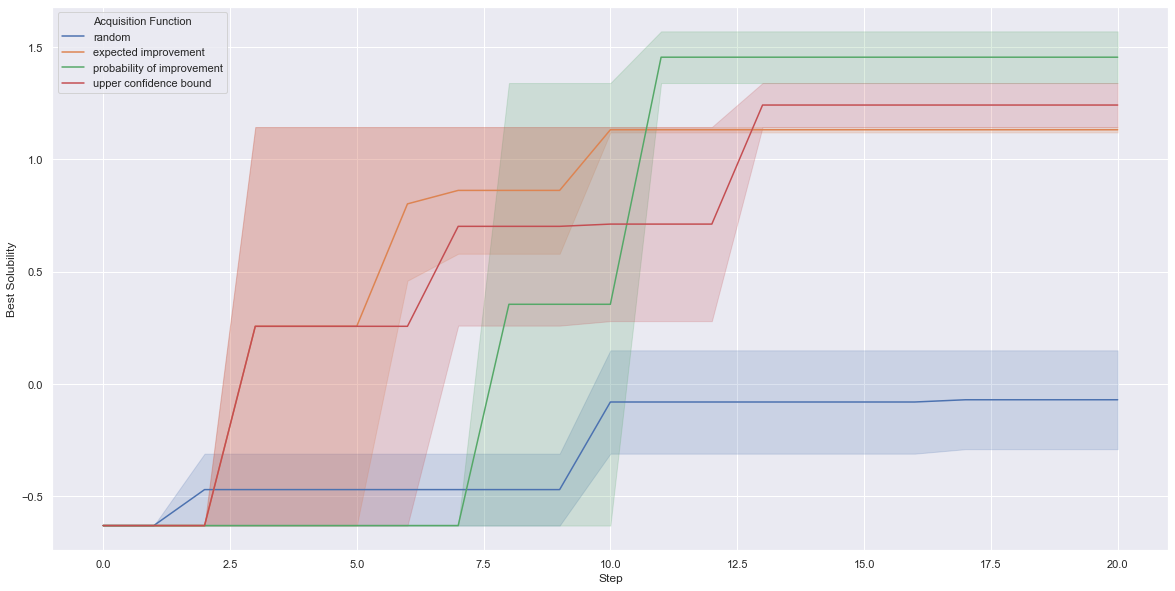

In [26]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
# fmri = sns.load_dataset("fmri")
plt.figure(figsize=(20,10))
ax = sns.lineplot(x="Step", y="Best Solubility", hue="Acquisition Function",
                  data=best_df)